https://discourse.pymc.io/t/mixture-model-with-boxcox-transformation/988

In [1]:
%pylab inline
import pymc3 as pm
from pymc3.theanof import gradient, floatX
from scipy import special
import numpy.testing as npt
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Box-Cox transformation

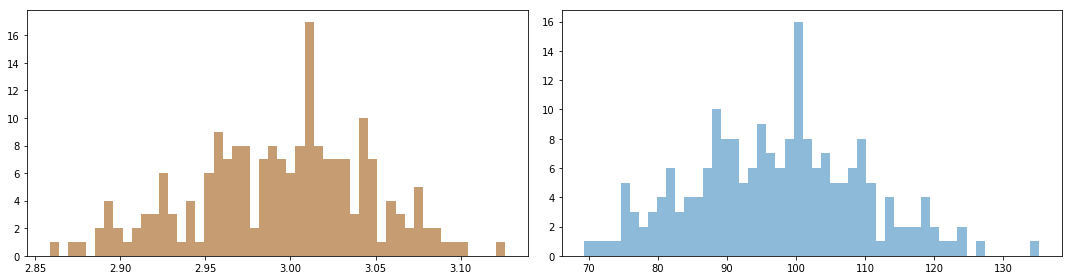

In [2]:
mu0, sd0 = 3., .05
y = np.random.normal(mu0, sd0, size=200)
lam = -.2
y_tr = special.inv_boxcox(y, lam)

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(y, bins=50, alpha=.5)
ax[0].hist(special.boxcox(y_tr, lam), bins=50, alpha=.5)
ax[1].hist(y_tr, bins=50, alpha=.5)
plt.tight_layout();

In [3]:
from pymc3.distributions.transforms import ElemwiseTransform

class BoxCox(ElemwiseTransform):
    """Box-Cox transformation from real line to real line"""

    name = "boxcox"

    def __init__(self, lmbda):
        self.lmbda = tt.as_tensor_variable(lmbda)

    def forward(self, x):
        # inverse box-cox transformation
        return tt.exp(tt.log1p(self.lmbda * x) / self.lmbda)

    def backward(self, y):
        # box-cox transformation
        return tt.expm1(self.lmbda * tt.log(y)) / self.lmbda

    def forward_val(self, y, point=None):
        lmbda = draw_values([self.lmbda], point=point)
        return np.exp(np.log1p(lmbda * y) / lmbda)

    def jacobian_det(self, x):
        x = tt.as_tensor_variable(x)
        grad = tt.reshape(gradient(tt.sum(self.backward(x)), [x]), x.shape)
        return tt.log(tt.abs_(grad))


boxcox = BoxCox(lam)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 2000/2000 [00:02<00:00, 714.57it/s]


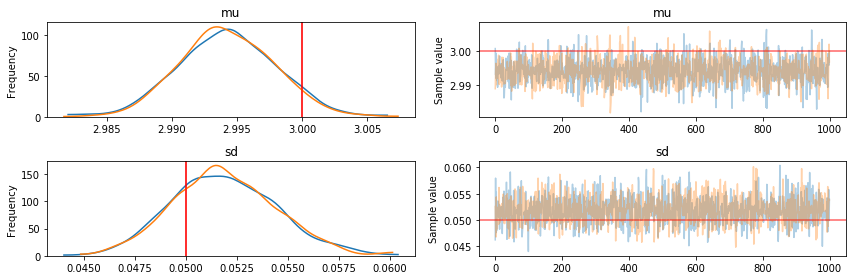

In [4]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.HalfNormal('sd', 5.)
    obs = pm.Normal('y', mu, sd, observed=boxcox.backward(y_tr))
    trace = pm.sample(1000, tune=1000)

pm.traceplot(trace, lines=dict(mu=mu0, sd=sd0));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_boxcox__]
100%|██████████| 6000/6000 [00:05<00:00, 1143.76it/s]


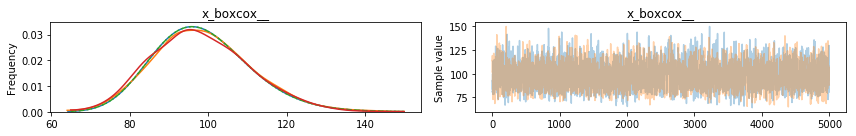

In [5]:
with pm.Model() as m:
    x = pm.Normal('x', mu0, sd0, transform=boxcox)
    trace = pm.sample(5000, tune=1000)

x_tr = m.free_RVs[0]
pm.traceplot(trace, varnames=[x_tr.name], priors=[x_tr.distribution]);

In [6]:
x_tr = m.free_RVs[0]
jac = x_tr.distribution.transform_used.jacobian_det(theano.shared(np.array([-1, 2])))
print(x.ndim, x_tr.logp_elemwiset.ndim, jac.ndim)

0 0 1


In [7]:
def check_elementwise_logp_transform(model):
    x0 = model.deterministics[0]
    x = model.free_RVs[0]
    npt.assert_equal(x.ndim, x.logp_elemwiset.ndim)
    
    pt = model.test_point
    array = np.random.randn(*model.bijection.map(pt).shape)
    pt2 = model.bijection.rmap(array)
    dist = x.distribution
    logp_nojac = x0.distribution.logp(dist.transform_used.backward(pt2[x.name]))
    jacob_det = dist.transform_used.jacobian_det(theano.shared(pt2[x.name]))
    npt.assert_equal(x.logp_elemwiset.ndim, jacob_det.ndim)
    elementwiselogp = logp_nojac + jacob_det
                      
    npt.assert_array_almost_equal(x.logp_elemwise(pt2),
                                  elementwiselogp.eval())
    
check_elementwise_logp_transform(m)

In [8]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10.)
    sd = pm.HalfNormal('sd', 5.)
    y_latent = pm.Normal('y', mu, sd, transform=boxcox, testval=2.)

In [9]:
m.free_RVs

[mu, sd_log__, y_boxcox__]

In [10]:
y_boxcox = m.free_RVs[2]

with m:
    obs = pm.Potential('obs', y_boxcox.distribution.logp(theano.shared(y_tr)))

In [11]:
m.check_test_point()

mu           -3.22
sd_log__     -0.77
y_boxcox__   -5.49
Name: Log-probability of test_point, dtype: float64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_boxcox__, sd_log__, mu]
100%|██████████| 6000/6000 [00:11<00:00, 501.53it/s] 


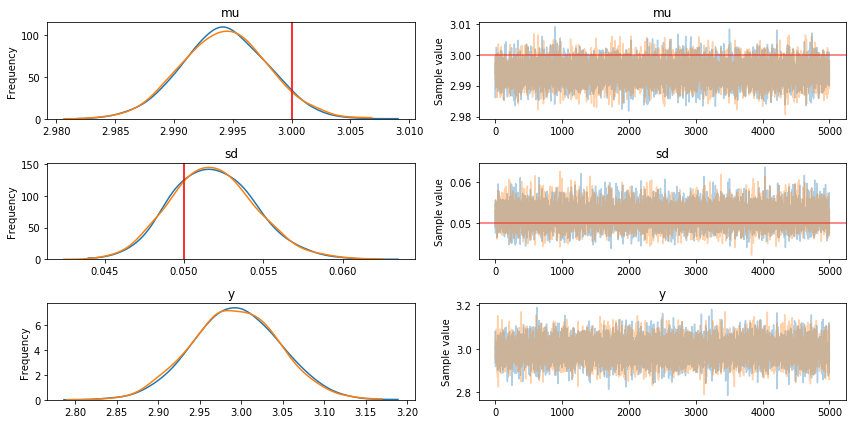

In [12]:
with m:
    trace = pm.sample(5000, tune=1000)

pm.traceplot(trace, lines=dict(mu=mu0, sd=sd0));

# Explicitly write down the distribution

In [13]:
from pymc3.distributions.continuous import Continuous
from pymc3.theanof import gradient


class BoxCoxNormal(Continuous):
    def __init__(self, mu=0., sd=1., lmbda=1., **kwargs):
        self.sd = tt.as_tensor_variable(sd)
        self.mu = tt.as_tensor_variable(mu)
        self.lmbda = tt.as_tensor_variable(lmbda)

        super(BoxCoxNormal, self).__init__(**kwargs)

    def inv_boxcox_func(self, x):
        return tt.exp(tt.log1p(self.lmbda * x) / self.lmbda)

    def boxcox_func(self, y):
        return tt.expm1(self.lmbda * tt.log(y)) / self.lmbda

    def jacobian_det(self, x):
        x = tt.as_tensor_variable(x)
        grad = tt.reshape(
            gradient(tt.sum(self.boxcox_func(x)), [x]), x.shape)
        return tt.log(tt.abs_(grad))

    def logp(self, value):
        sd = self.sd
        mu = self.mu
        value_ = self.boxcox_func(value)
        return pm.Normal.dist(mu, sd).logp(value_) + self.jacobian_det(value)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 6000/6000 [00:06<00:00, 857.60it/s] 


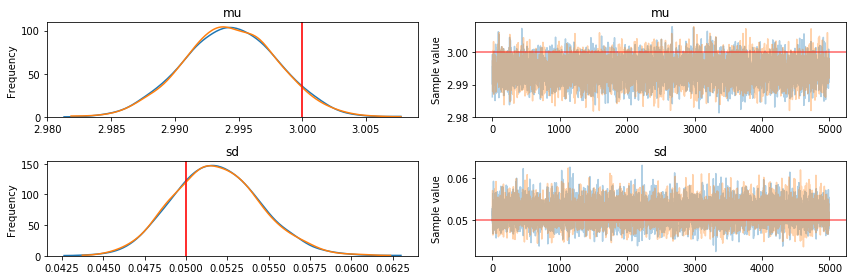

In [14]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10.)
    sd = pm.HalfNormal('sd', 5.)
    y_latent = BoxCoxNormal('y', mu, sd, lmbda=lam, observed=y_tr)
    trace = pm.sample(5000, tune=1000)

pm.traceplot(trace, lines=dict(mu=mu0, sd=sd0));

# mixture

In [15]:
np.random.seed(12345)  # set random seed for reproduciblity
k = 2
ndata = 4500
ndata2 = 500

mu0, mu1 = 3.1, 2.9
# mu0, mu1 = 3.1, 2.5
sd0, sd1 = np.sqrt(0.014), np.sqrt(0.022)

# simulate data from mixture distribution
data_ = np.random.normal(loc=mu0, scale=sd0, size=ndata)
data2_ = np.random.normal(loc=mu1, scale=sd1, size=ndata2)

# lambdas for the boxcox transformation
ld_1 = -0.18
ld_2 = -0.26

# Back convert the guassians to the original data scale
data = special.inv_boxcox(data_, ld_1)
data2 = special.inv_boxcox(data2_, ld_2)

combi_data_ = np.concatenate((data_, data2_), axis=0)
# Make the final array
combi_data = np.concatenate((data, data2), axis=0)
np.random.shuffle(combi_data)

n = ndata + ndata2

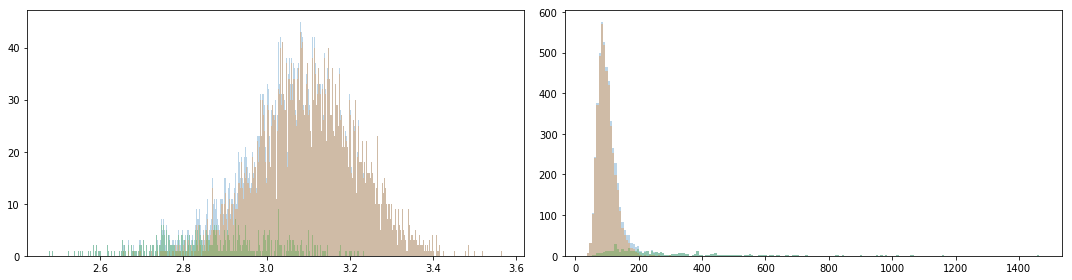

In [16]:
_, ax = plt.subplots(1, 2, figsize=(15, 4))

bin0 = np.linspace(combi_data_.min(), combi_data_.max(), 500)
ax[0].hist(combi_data_, bin0, alpha=.3)
ax[0].hist(data_, bin0, alpha=.3)
ax[0].hist(data2_, bin0, alpha=.3)

bin1 = np.linspace(combi_data.min(), combi_data.max(), 200)
ax[1].hist(combi_data, bin1, alpha=.3)
ax[1].hist(data, bin1, alpha=.3)
ax[1].hist(data2, bin1, alpha=.3)
plt.tight_layout();

In [17]:
with pm.Model() as m:
    w = pm.Dirichlet('w', a=np.ones(2))
    mus = pm.Normal('mus', 2.8, 5., shape=2)
    sds = pm.HalfNormal('sds', .5, shape=2)
    mix_logp = [BoxCoxNormal.dist(mus[0], sds[0], lmbda=ld_1),
                BoxCoxNormal.dist(mus[1], sds[1], lmbda=ld_2),]
    obs = pm.Mixture('y', w, mix_logp, observed=combi_data)

In [18]:
m.check_test_point()

mus                     -5.06
sds_log__               -1.54
w_stickbreaking__       -1.39
y                   -29408.76
Name: Log-probability of test_point, dtype: float64

In [19]:
with m:
    map1 = pm.find_MAP()

map1

logp = -24,865, ||grad|| = 3.6728: 100%|██████████| 44/44 [00:00<00:00, 611.24it/s]


{'mus': array([3.10526658, 2.9556691 ]),
 'sds': array([0.12033735, 0.11749525]),
 'sds_log__': array([-2.11745627, -2.14135737]),
 'w': array([0.93254566, 0.06745434]),
 'w_stickbreaking__': array([2.62646723])}

In [20]:
print(mu0, mu1)
print(sd0, sd1)

3.1 2.9
0.11832159566199232 0.14832396974191325


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sds_log__, mus, w_stickbreaking__]
100%|██████████| 2000/2000 [00:41<00:00, 47.74it/s]
The number of effective samples is smaller than 25% for some parameters.


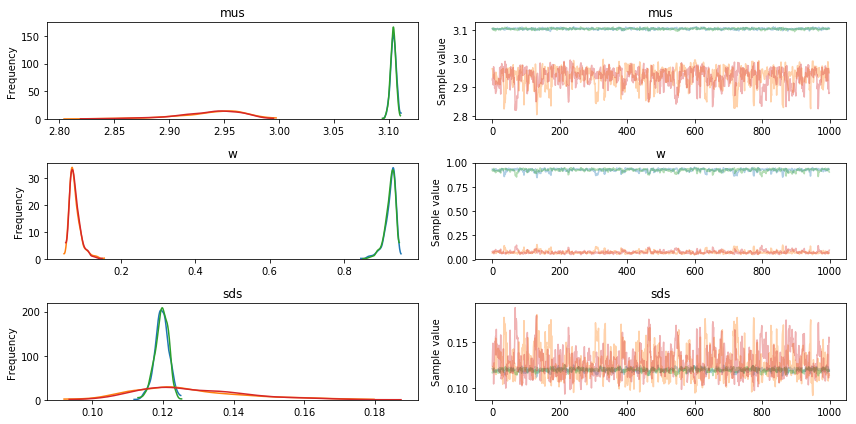

In [21]:
with m:
    trace = pm.sample(1000, tune=1000, start=map1)

pm.traceplot(trace);

# with informative prior

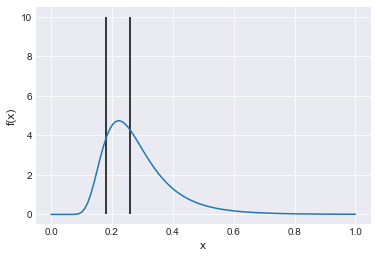

In [23]:
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 1, 100)
alphas = [8.]
betas = [2.]
for a, b in zip(alphas, betas):
    pdf = st.invgamma.pdf(x, a, scale=b)
    plt.plot(x, pdf)
plt.vlines(-ld_1, 0, 10)
plt.vlines(-ld_2, 0, 10)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [29]:
with pm.Model() as m:
    w = pm.Dirichlet('w', a=np.ones(2))
    mus = pm.Normal('mus', 2.8, 5., shape=2)
    sds = pm.HalfNormal('sds', .5, shape=2)
    lmbdas = pm.InverseGamma('lambdas', 8., 2., shape=2,
                             testval=np.asarray([-ld_1, -ld_2]))
    mix_logp = [BoxCoxNormal.dist(mus[0], sds[0], lmbda=-lmbdas[0]),
                BoxCoxNormal.dist(mus[1], sds[1], lmbda=-lmbdas[1]),]
    obs = pm.Mixture('y', w, mix_logp, observed=combi_data)

In [30]:
m.check_test_point()

lambdas_log__           -0.27
mus                     -5.06
sds_log__               -1.54
w_stickbreaking__       -1.39
y                   -29408.76
Name: Log-probability of test_point, dtype: float64

In [31]:
with m:
    # using the MAP from the above model to help convergence
    map2 = pm.find_MAP(start=map1)

map2

logp = -24,862, ||grad|| = 5.5607: 100%|██████████| 5/5 [00:00<00:00, 314.68it/s]


{'lambdas': array([0.18000287, 0.25999792]),
 'lambdas_log__': array([-1.71478248, -1.34708164]),
 'mus': array([3.10526664, 2.95566911]),
 'sds': array([0.12033735, 0.11749525]),
 'sds_log__': array([-2.11745625, -2.14135737]),
 'w': array([0.93254566, 0.06745434]),
 'w_stickbreaking__': array([2.62646723])}

In [32]:
print(mu0, mu1)
print(sd0, sd1)
print(-ld_1, -ld_2)

3.1 2.9
0.11832159566199232 0.14832396974191325
0.18 0.26


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambdas_log__, sds_log__, mus, w_stickbreaking__]
INFO:pymc3:NUTS: [lambdas_log__, sds_log__, mus, w_stickbreaking__]
100%|██████████| 2000/2000 [31:49<00:00,  1.65it/s] 
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


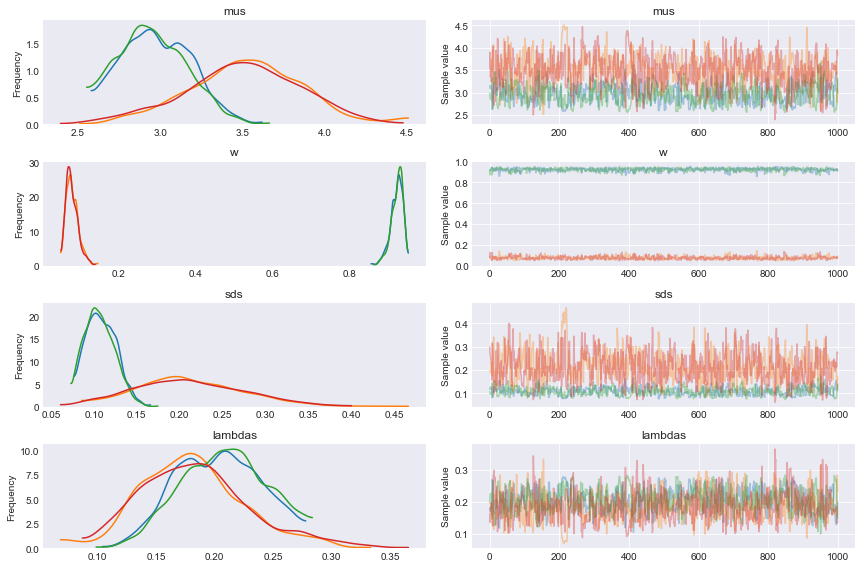

In [34]:
with m:
    trace = pm.sample(1000, tune=1000, start=map2, init='adapt_diag')

pm.traceplot(trace);